# Fitting line profiles with lorentzian and Gausian

In [12]:
import data_analysis as da
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
import os
from importlib import reload
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from scipy.interpolate import interp1d


In [13]:
lines = ["Ha17", "CaK17", "CaII17"]
long_names = {"Ha17":r"H$\alpha$", "CaK17":r'Ca$IIK$', "CaII17":r'Ca$II 8542 \AA$'}


data0 = un.load_for_further_analysis(lines)
un2.disgard_cont_point("CaK17", data0)
data0.keys()

dict_keys(['FOV_Ha17', 'quiet_sun_Ha17', 'nessi_Ha17', 'TIME_Ha17', 'FOV_CaK17', 'quiet_sun_CaK17', 'nessi_CaK17', 'TIME_CaK17', 'FOV_CaII17', 'quiet_sun_CaII17', 'nessi_CaII17', 'TIME_CaII17'])

In [14]:
data0['quiet_sun_Ha17']

array([[6.56150000e+03, 6.56200000e+03, 6.56220000e+03, 6.56240000e+03,
        6.56270000e+03, 6.56285000e+03, 6.56300000e+03, 6.56315000e+03,
        6.56330000e+03, 6.56360000e+03, 6.56380000e+03, 6.56400000e+03,
        6.56450000e+03],
       [2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08],
       [5.22207581e-02, 3.78950462e-02, 4.08104956e-02, 8.45079795e-02,
        9.83282924e-02, 9.55938324e-02, 9.06255320e-02, 9.14372727e-02,
        8.36121216e-02, 4.07840125e-02, 3.61596309e-02, 3.84186432e-02,
        5.16747981e-02]])

In [15]:
wav, spec, std = data0['quiet_sun_Ha17']
wav, spec


(array([6561.49999988, 6562.        , 6562.19999999, 6562.39999998,
        6562.69999999, 6562.84999999, 6563.        , 6563.15000001,
        6563.30000001, 6563.60000002, 6563.80000001, 6564.        ,
        6564.50000012]),
 array([2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08]))

Lorentzian: $$f(x)= {\frac {1}{\pi \gamma \,\left[1+\left({\frac {x-x_{0}}{\gamma }}\right)^{2}\right]}}$$

gausian: $$ f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}$$
$$y_0  \exp(-\left(\frac{(x - x_0)}{(\sigma * \sqrt(2  \log(2)))}\right)^2)$$

In [19]:
reload(un2)
wav, DFOV , time, line, std = un2.contrast_FOV_data('Ha17', data0, quiet_sun_subtraction=False, num=20)
wav, DFOV , time, line 

(array([6561.49999988, 6561.65789463, 6561.81578938, 6561.97368413,
        6562.13157888, 6562.28947363, 6562.44736838, 6562.60526313,
        6562.76315788, 6562.92105263, 6563.07894737, 6563.23684212,
        6563.39473687, 6563.55263162, 6563.71052637, 6563.86842112,
        6564.02631587, 6564.18421062, 6564.34210537, 6564.50000012]),
 array([[ 0.00721098,  0.02437314,  0.04488658, ...,  0.09023289,
          0.12780213,  0.01229937],
        [ 0.00800826,  0.02504565,  0.04543431, ...,  0.09756207,
          0.1363941 ,  0.02215414],
        [ 0.01733764,  0.03583724,  0.05768812, ...,  0.10685714,
          0.14486771,  0.02980627],
        ...,
        [-0.15422236, -0.14179212, -0.12601061, ..., -0.1066206 ,
         -0.06341475, -0.1732809 ],
        [-0.15383673, -0.14169897, -0.12620993, ..., -0.10550586,
         -0.06184113, -0.1712484 ],
        [-0.15558441, -0.14249761, -0.12605954, ..., -0.1063728 ,
         -0.06198497, -0.17066914]]),
 array([-2.25000000e+00, -2.000

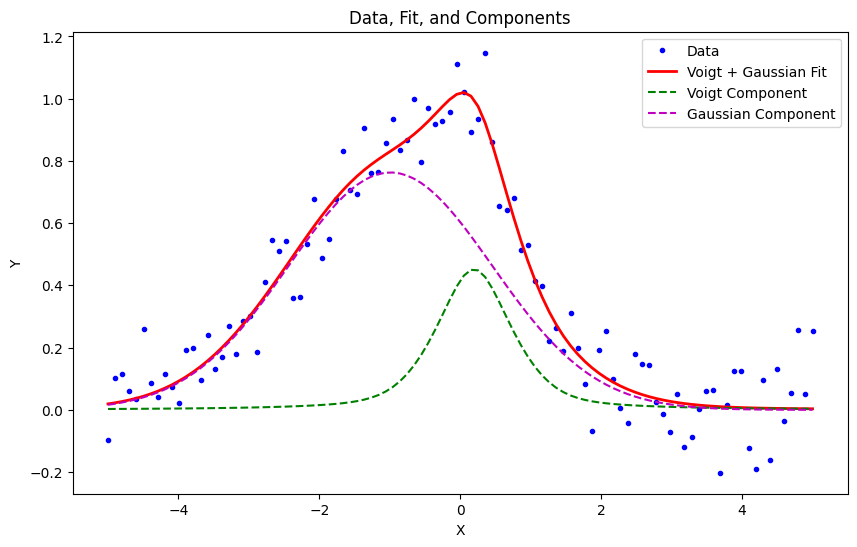

In [60]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, amp_v, cen_v, sigma_v, gamma_v, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def voigt_plus_gaussian(x, amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g):
    """Combination of a Voigt profile and an additional Gaussian."""
    return voigt(x, amp_v, cen_v, sigma_v, gamma_v) + gaussian(x, amp_g, cen_g, sigma_g)

def fit_voigt_and_gaussian(x_data, y_data, initial_guess):
    """Fit a Voigt and Gaussian profile to the data."""
    popt, pcov = curve_fit(voigt_plus_gaussian, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def fit_voigt(x_data, y_data, initial_guess):
    """Fit a Voigt profile to the data."""
    popt, pcov = curve_fit(voigt, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def plot_data_fit_and_components(x_data, y_data, initial_guess, popt=None):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt_and_gaussian(x_data, y_data, initial_guess)
    y_fit = voigt_plus_gaussian(x_data, *popt)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])
    y_gaussian = gaussian(x_data, popt[4], popt[5], popt[6])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'b.', label='Data')
    plt.plot(x_data, y_fit, 'r-', linewidth=2, label='Voigt + Gaussian Fit')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_gaussian, 'm--', label='Gaussian Component')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
def plot_data_fit_voigt(x_data, y_data, initial_guess, popt=None):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt(x_data, y_data, initial_guess)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])
    y_diff = y_data - y_voigt
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'b.', label='Data')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_diff, 'r--', label='residue')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Generate synthetic data
x = np.linspace(-5, 5, 100)
y = voigt_plus_gaussian(x, 1, 0, 1, 0.5, 0.5, -2, 1) + np.random.normal(0, 0.1, len(x))

# Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
initial_guess = [1, 0, 1, 1, 0.5, 0, 1]

# Plot the data, the fit, and the individual components
plot_data_fit_and_components(x, y, initial_guess)

In [99]:
def contrast_fit_voight_gauss(wav, contrast, intitial_guess, plot_rate=1000):

    param_fit = [] 
    residuals = []
    
    for i in range( np.shape(contrast)[0]):
        param_fit.append(fit_voigt_and_gaussian(wav, contrast[i], initial_guess))
        print(param_fit[i])
        
        if i%plot_rate == plot_rate-1:
            plot_data_fit_and_components(wav, contrast[i], initial_guess)
            
        popt = param_fit[-1][0]
        y_data = contrast[i]
        y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
        y_diff = y_data - y_voigt
        residuals.append(y_diff)
        
    return param_fit, residuals
        
        
def contrast_fit_voight(wav, contrast, initial_guess, plot_rate=1000):

    param_fit = [] 
    y_fits = []
    residuals = []
    
    
    for i in range( np.shape(contrast)[0]):
        try:
            param_fit.append(fit_voigt(wav, contrast[i], initial_guess.copy()))
            
            
            if i%plot_rate == plot_rate-1:
                print(f'{param_fit[-1] = }. Here comes the plot:')
                plot_data_fit_voigt(wav, contrast[i], initial_guess)
                
            popt = param_fit[-1][0]
            y_data = contrast[i]
            y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
            y_fits.append(y_voigt)
            y_diff = y_data - y_voigt
            residuals.append(y_diff)
        except RuntimeError:
            param_fit.append(initial_guess)
    try:
        return np.array(param_fit), np.array(y_fits) , np.array(residuals)
    except ValueError as error:
        print('The lenght of those arrays does not work out')
        print("the shapes of the param_fits:", [np.shape(k) of k in param_fit])
        print("the shapes of the y_fits:", [np.shape(k) of k iny_fits])
        print("the shapes of the residuals:", [np.shape(k) of k inresiduals])
        raise error
        
        
        
def make_analysis(name, data, initial_guess, plot_rate=50, offset=0):
    wav, DFOV , time, line, std = un2.contrast_FOV_data(name, data, quiet_sun_subtraction=False, num=20)
    # print(np.shape(wav), np.shape(DFOV), np.shape(time), np.shape(line))
    # Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
    params, voight, res = contrast_fit_voight(wav, DFOV+offset, initial_guess, plot_rate)
    visualize_analysis(res, voight, wav, time, name)

def visualize_analysis(res, voight, wav, time, name):
    fig, ax = plt.subplots()

    c = ax.imshow(np.array(res), aspect="auto", origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    X, Y = np.meshgrid(wav, time)
    CS = ax.contour(X, Y, voight, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    ax.set_xlabel(r"Wavelength [$\AA$]")
    ax.set_ylabel('time from start of flare [min]')
    ax.set_title(f"Voigth fit and Residue analysis for {name} flare")
    cb.set_label(r'the residues after Voigt fit [relative intensity]')
    plt.show()   
    
initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[1.5,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04]}

def element_from_name(name):
    lines = ['Ha', 'CaK', 'CaI', "Fe"]
    for line in lines:
        if line in name:
            return "CaIR" if line=="CaI" else line
    raise ValueError(f'The given name {name} is not known as a spectral name (yet).')


def make_full_analysis(data, names_list, offsets=None, plot_rate=500):
    if offsets is None:
        offsets = np.zeros(len(names_list))
    for i, name in enumerate(names_list):
        el = element_from_name(name)
        make_analysis(name, data, initial_guesses[el], plot_rate, offset=offsets[i])
        

SyntaxError: invalid syntax. Perhaps you forgot a comma? (866298642.py, line 50)

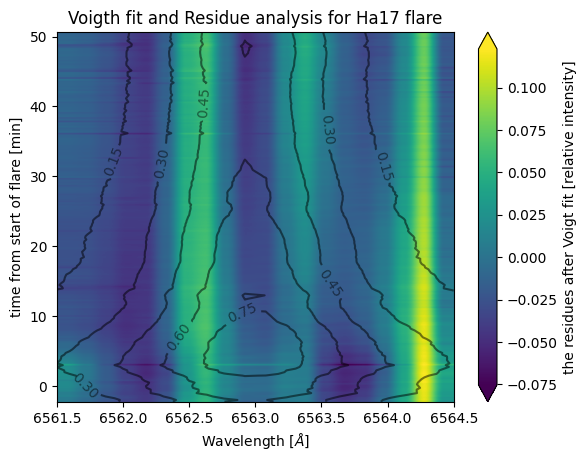

In [70]:
make_analysis('Ha17', data0,[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], plot_rate=1500, offset=0.19)

param_fit[-1] = (array([ 1.07643708e+00,  8.54202940e+03, -2.35235931e-01, -5.93577114e-05]), array([4.73005414e-01, 6.91239722e-03, 6.64604632e-03, 2.01973560e+02])). Here comes the plot:


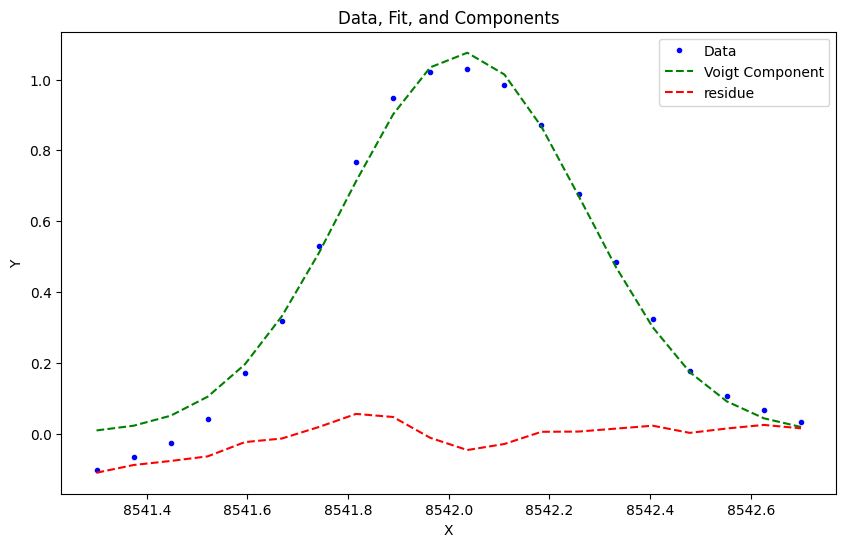

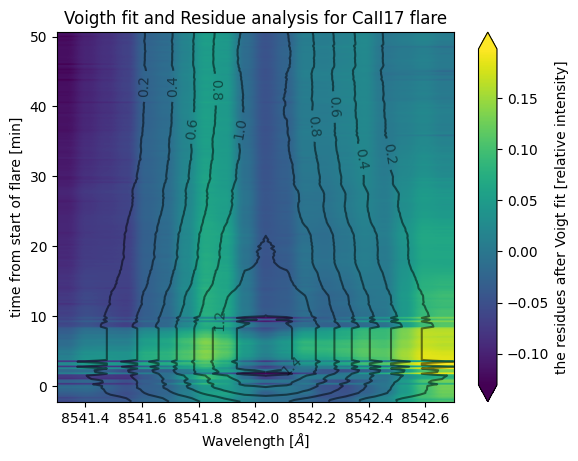

In [58]:
make_analysis('CaII17', data0,[1.5,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04], plot_rate=150)

param_fit[-1] = (array([ 6.23191746e+00,  3.93366396e+03, -2.03620063e-01,  3.02910706e-01]), array([0.09214411, 0.00386757, 0.01465466, 0.00634567])). Here comes the plot:


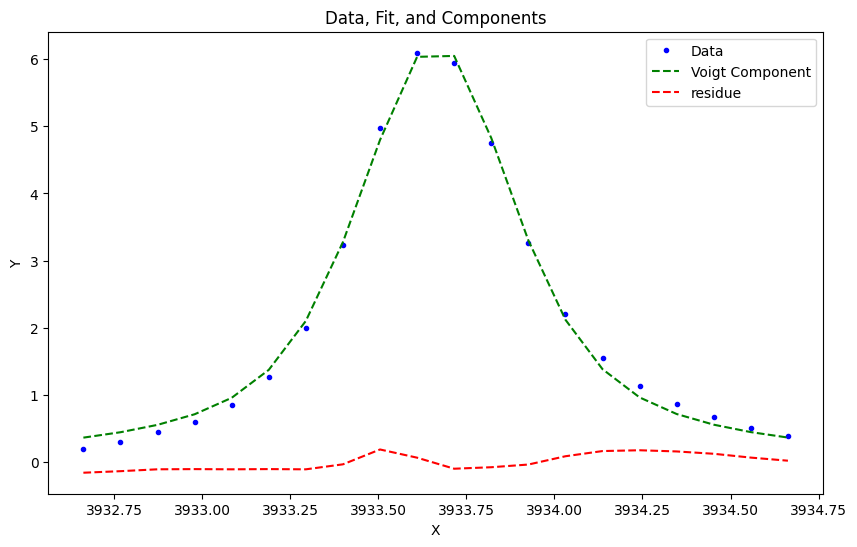

param_fit[-1] = (array([ 4.92324818e+00,  3.93366057e+03, -2.04490114e-01,  2.46998294e-01]), array([0.04650683, 0.00224982, 0.0072624 , 0.00515962])). Here comes the plot:


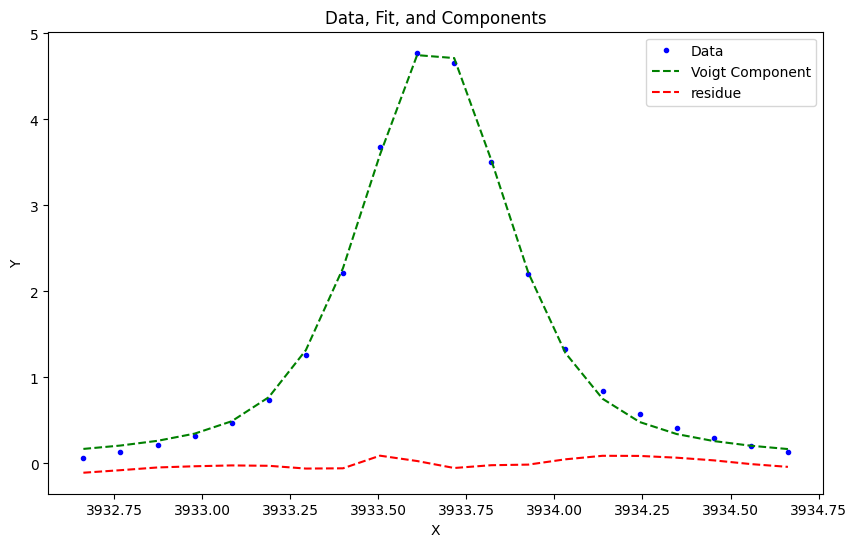

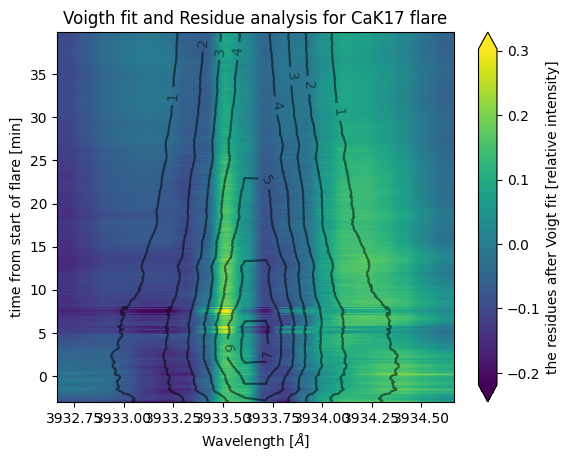

In [51]:
make_analysis('CaK17', data0,[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], plot_rate=150, offset=0.5)

# X2.2 flare at 9 o'clock

In [78]:
lines = ["Ha17_9u"]
long_names = {"Ha17_9u":r"H$\alpha$"}

data = un.load_for_further_analysis(lines)
data.keys()

dict_keys(['FOV_Ha17_9u', 'quiet_sun_Ha17_9u', 'nessi_Ha17_9u', 'TIME_Ha17_9u'])

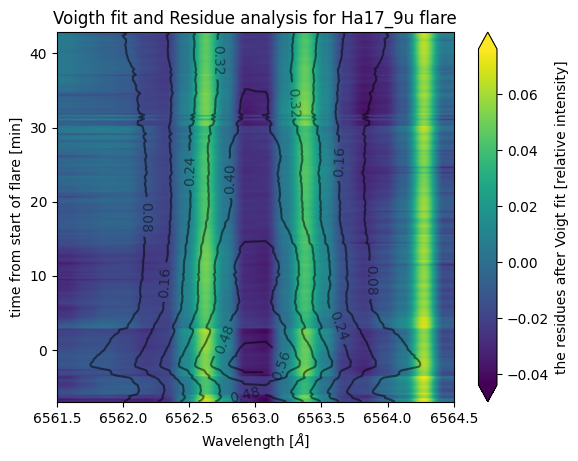

In [92]:
make_full_analysis(data, lines, offsets=[0.2])

# the C1.3 flare 2013

In [94]:
reload(un)
lines = ["Ha13"]
long_names = {"Ha13":r"H$\alpha$ 2013"}

data = un.load_for_further_analysis(lines, full_path = "D:\solar flares\data\\2013-06-30")
print(data.keys())


dict_keys(['FOV_Ha13', 'quiet_sun_Ha13', 'nessi_Ha13', 'TIME_Ha13'])


param_fit[-1] = (array([ 1.59966536e-01,  6.56306525e+03,  2.30578983e-01, -1.22609525e-04]), array([5.48256849e+00, 1.05004659e-01, 8.81966481e-02, 7.33648941e+03])). Here comes the plot:


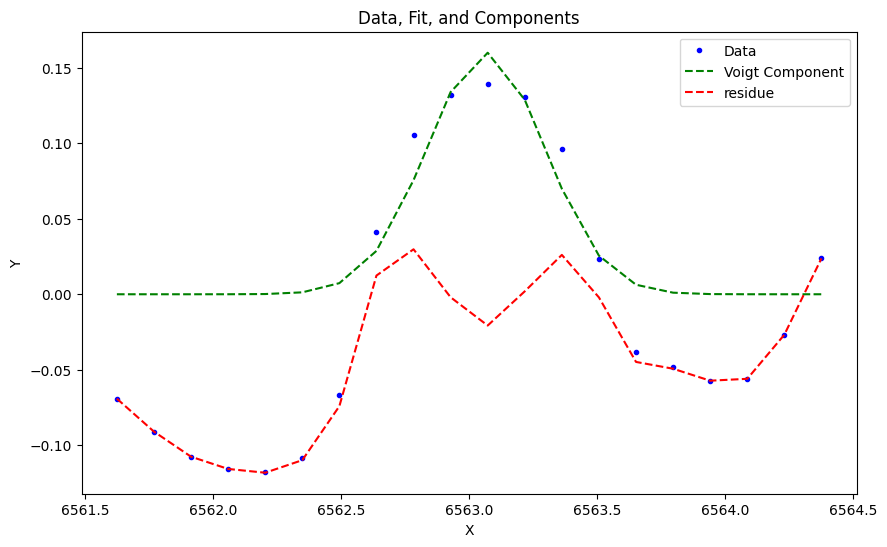

param_fit[-1] = (array([1.27037394e-01, 6.56298739e+03, 2.41645508e-01, 4.93658068e-04]), array([1.13796433e+02, 1.16073882e-01, 1.59301999e-01, 1.64178610e+04])). Here comes the plot:


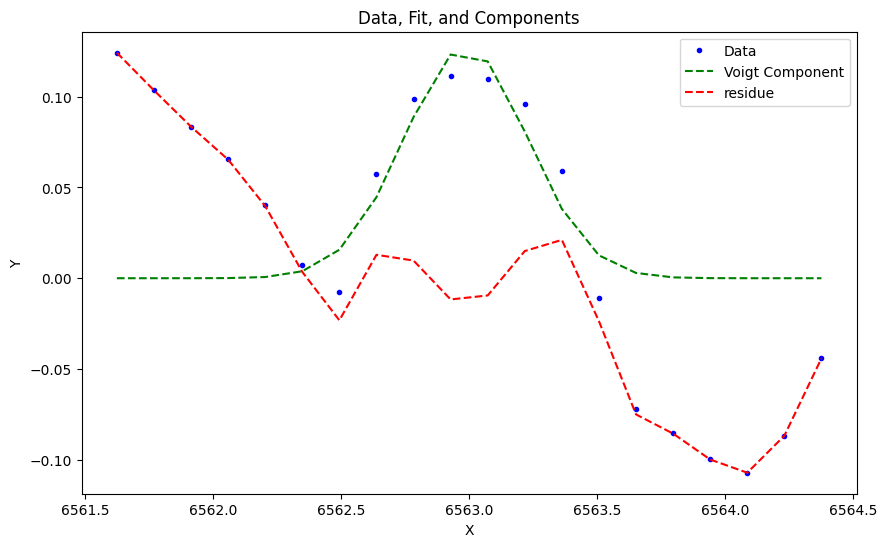

param_fit[-1] = (array([ 1.15394263e-01,  6.56300934e+03, -2.33147867e-01,  1.13040396e-03]), array([7.84829604e+01, 8.24821381e-02, 8.31640926e-02, 2.39827156e+04])). Here comes the plot:


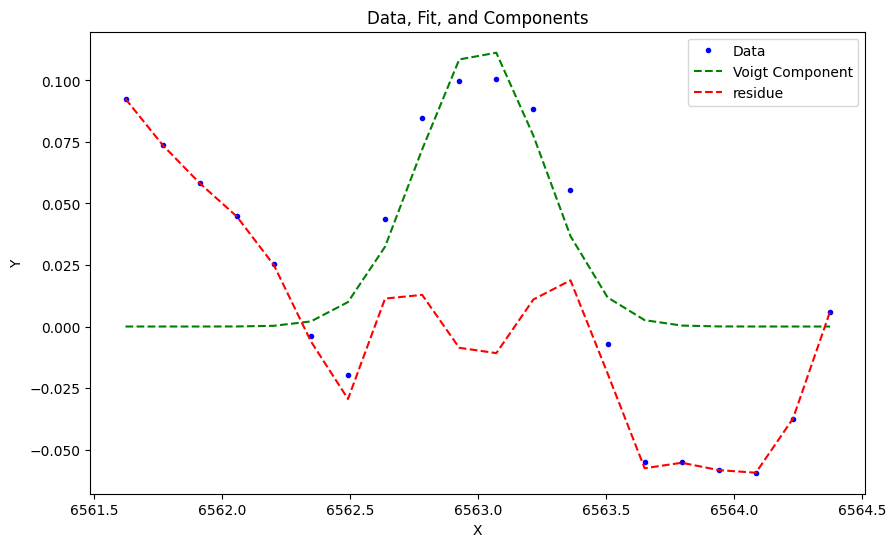

param_fit[-1] = (array([9.25617548e-02, 6.56305525e+03, 2.18847193e-01, 4.73465420e-04]), array([1.23944692e+01, 6.09539645e-02, 6.97567617e-02, 4.44408938e+03])). Here comes the plot:


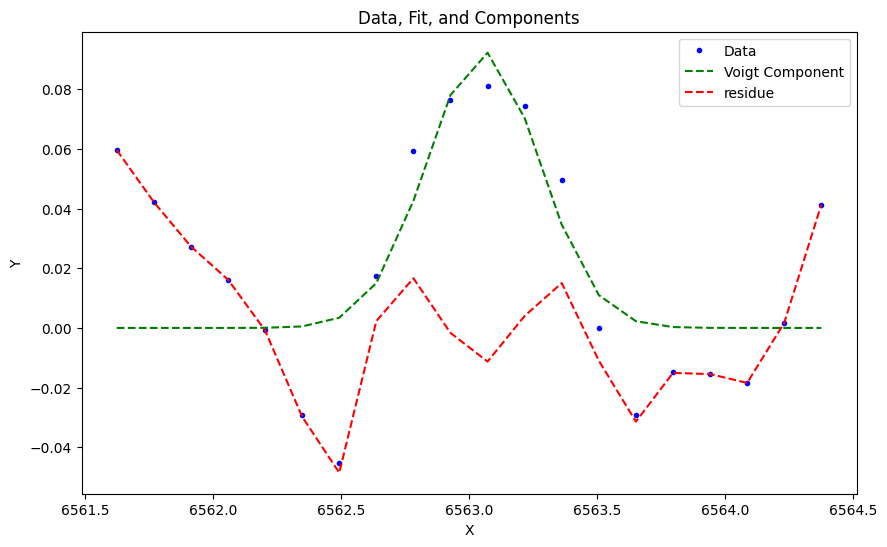

param_fit[-1] = (array([ 7.74246556e-02,  6.56307041e+03, -2.06240966e-01, -1.52053458e-05]), array([2.94453307e-02, 7.64138575e-02, 7.98504519e-02, 7.19340769e+02])). Here comes the plot:


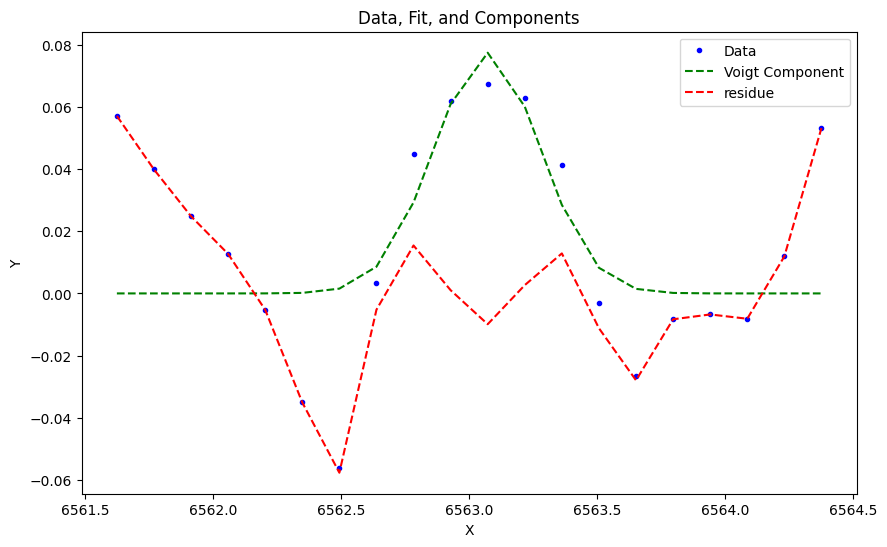

param_fit[-1] = (array([ 7.02393682e-02,  6.56307396e+03,  1.97706565e-01, -9.35622731e-06]), array([inf, inf, inf, inf])). Here comes the plot:


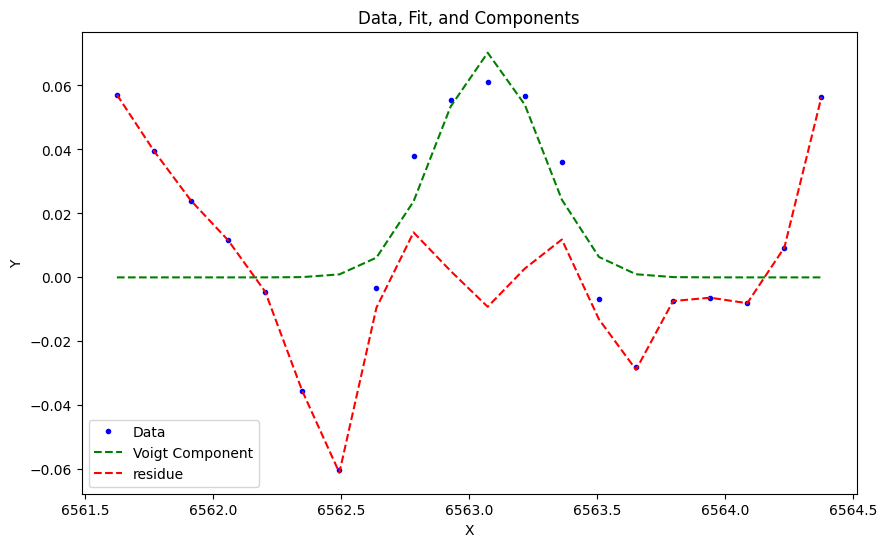

param_fit[-1] = (array([8.23373781e-01, 6.56124794e+03, 4.56575849e-04, 1.04532795e-01]), array([2.05670508e+03, 3.68160253e+00, 2.40706136e+04, 8.58559758e+00])). Here comes the plot:


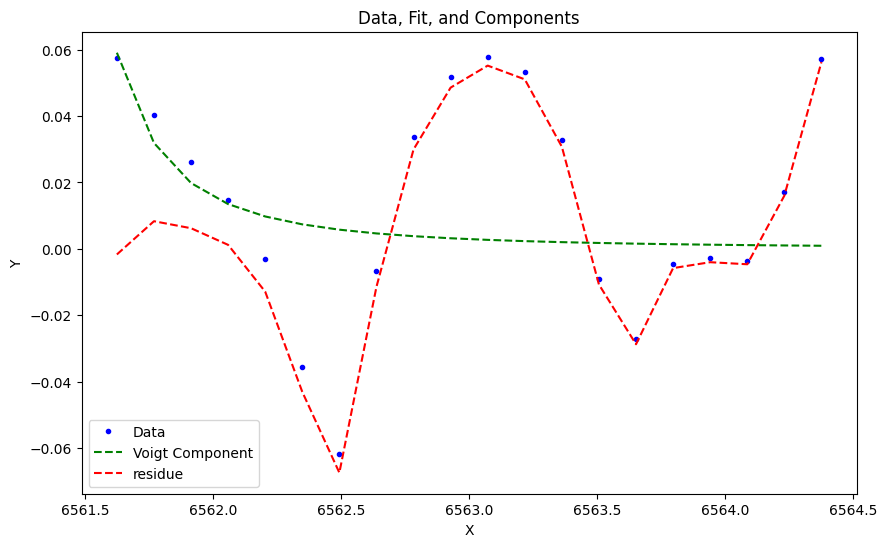

param_fit[-1] = (array([ 4.55609921e+04,  6.55620016e+03,  1.03668948e+00, -5.37656302e-02]), array([6.00873832e+06, 5.94867755e+01, 6.53313827e+00, 1.38719284e+00])). Here comes the plot:


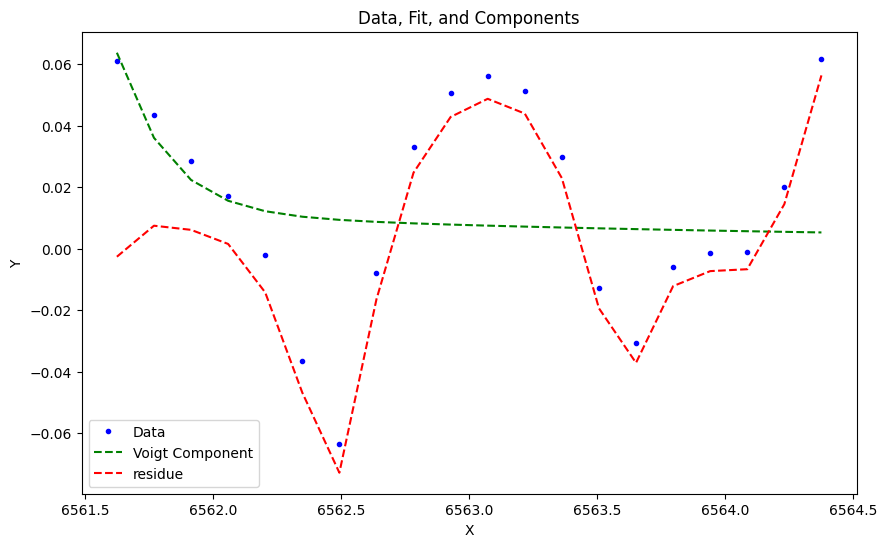

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (504,) + inhomogeneous part.

In [96]:
make_full_analysis(data, lines, offsets=[0], plot_rate=50)

# C2.2 flare 2019

In [97]:
reload(un)
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
offsets = [0, 0, 0]
long_names = {"Fe6173_2019":r"Fe 6173", "CaK19":r'Ca$IIK$', "CaIR19":r'Ca$II 8542 \AA$'}


data = un.load_for_further_analysis(lines, full_path = "D:\solar flares\data\\2019-05-06")
un2.disgard_cont_point("CaK19", data)

print(data.keys())


dict_keys(['FOV_CaIR19', 'quiet_sun_CaIR19', 'nessi_CaIR19', 'TIME_CaIR19', 'FOV_Fe6173_2019', 'quiet_sun_Fe6173_2019', 'nessi_Fe6173_2019', 'TIME_Fe6173_2019', 'FOV_CaK19', 'quiet_sun_CaK19', 'nessi_CaK19', 'TIME_CaK19'])


In [98]:
make_full_analysis(data, lines, offsets=offsets)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (171,) + inhomogeneous part.